In [1]:
# %tensorflow_version 1.x # 確保使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\l

1.13.1


In [2]:
# 需要安裝 keras 2.2.4 的版本
# pip install keras==2.2.4 

In [3]:
# 如果之前已經下載過就可以註解掉
# !git clone https://github.com/qqwweee/keras-yolo3 

In [4]:
%cd keras-yolo3

C:\Users\User\CV\Final\keras-yolo3


In [5]:
import os
from xml.etree import ElementTree
import numpy as np

In [6]:
if not os.path.exists('model_data/yolov3.h5'):
    # os.system('wget https://pjreddie.com/media/files/yolov3.weights')
    os.system('python convert.py yolov3.cfg yolov3.weights model_data/yolov3.h5')
else:
    pass

In [7]:
if not os.path.exists('animals_train.txt'):
    sets = ['train', 'val']
    
    classes = ["kangaroo", "raccoon"]
    
    def dump_info(xml_path, list_file):
        f = open(xml_path)
        tree = ElementTree.parse(f)
        root = tree.getroot()
        
        for obj in tree.iter('object'):
            diff = int(obj.find('difficult').text)
            cls_name = obj.find('name').text
            
            if cls_name not in classes or diff == 1:
                continue
                
            cls_index = classes.index(cls_name)
            bndbox = obj.find('bndbox')
            
            b = (int(bndbox.find('xmin').text), int(bndbox.find('ymin').text), int(bndbox.find('xmax').text), int(bndbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_index))
            
        f.close()
        
    
    images_dir = ['animals/kangaroo/images', 'animals/raccoon/images']
    for s in sets:
        list_file = open('animals_%s.txt' % s, 'w')
        
        for i, annotation_path in enumerate(['animals/kangaroo/annots', 'animals/raccoon/annotations']):
            annots = os.listdir(annotation_path)
            annots.sort()
            annot_size = len(annots)
            split_num = int(np.round(annot_size * 0.8))
        
            if s == 'train':
                data = annots[:split_num]
            else:
                data = annots[split_num:]
                
            for d in data:
                name = d.split('.')[0]
                list_file.write(os.path.join(images_dir[i], '%s.jpg' % name))
                dump_info(os.path.join(annotation_path, d), list_file)
                list_file.write('\n')
        
        list_file.close()

In [8]:
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

import time

Using TensorFlow backend.


In [9]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [10]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

K.set_session(sess)

In [11]:
from train import get_classes, get_anchors, create_model, create_tiny_model

In [12]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes, is_train=True):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0 and is_train:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=is_train)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

In [13]:
annotation_path = 'animals_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/%s/' % str(int(time.time()))# 訓練好的模型儲存的路徑
classes_path = 'model_data/animal_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo.h5')
else:
    model = create_model(input_shape, anchors, num_classes, 
        freeze_body=2, weights_path='model_data/yolo.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    train_lines = f.readlines()
with open('animals_val.txt') as f:
    val_lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(train_lines)
np.random.seed(None)
num_val = len(val_lines)
num_train = len(train_lines)

Create YOLOv3 model with 9 anchors and 2 classes.


C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages

Load weights model_data/yolo.h5.
Freeze the first 249 layers of total 252 layers.


In [14]:
# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 4
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    history = model.fit_generator(data_generator(train_lines, batch_size, input_shape, anchors, num_classes, True),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator(val_lines, batch_size, input_shape, anchors, num_classes, False),
            validation_steps=max(1, num_val//batch_size),
            epochs=100,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

Train on 291 samples, val on 73 samples, with batch size 4.
Epoch 1/100
72/72 [==============================] - 29s 400ms/step - loss: 1402.3666 - val_loss: 148.1244
Epoch 2/100
72/72 [==============================] - 24s 337ms/step - loss: 124.8072 - val_loss: 77.7069
Epoch 3/100
72/72 [==============================] - 24s 327ms/step - loss: 77.1425 - val_loss: 53.8408
Epoch 4/100
72/72 [==============================] - 23s 326ms/step - loss: 57.7162 - val_loss: 42.4004
Epoch 5/100
72/72 [==============================] - 23s 326ms/step - loss: 45.6298 - val_loss: 35.0216
Epoch 6/100
72/72 [==============================] - 23s 326ms/step - loss: 39.4760 - val_loss: 30.7526
Epoch 7/100
72/72 [==============================] - 24s 327ms/step - loss: 34.8758 - val_loss: 28.0139
Epoch 8/100
72/72 [==============================] - 24s 326ms/step - loss: 31.7507 - val_loss: 26.6535
Epoch 9/100
72/72 [==============================] - 23s 326ms/step - loss: 29.7165 - val_loss: 24.7641


72/72 [==============================] - 24s 328ms/step - loss: 16.7326 - val_loss: 16.0271
Epoch 79/100
72/72 [==============================] - 24s 327ms/step - loss: 16.6046 - val_loss: 16.0828
Epoch 80/100
72/72 [==============================] - 23s 326ms/step - loss: 16.3267 - val_loss: 16.2092
Epoch 81/100
72/72 [==============================] - 23s 326ms/step - loss: 16.7355 - val_loss: 16.7873
Epoch 82/100
72/72 [==============================] - 24s 327ms/step - loss: 16.3322 - val_loss: 16.2546
Epoch 83/100
72/72 [==============================] - 24s 329ms/step - loss: 16.3959 - val_loss: 15.9423
Epoch 84/100
72/72 [==============================] - 24s 330ms/step - loss: 16.2592 - val_loss: 16.5763
Epoch 85/100
72/72 [==============================] - 24s 330ms/step - loss: 16.6536 - val_loss: 16.9542
Epoch 86/100
72/72 [==============================] - 24s 330ms/step - loss: 16.6572 - val_loss: 16.5975
Epoch 87/100
72/72 [==============================] - 24s 329ms/step

In [15]:
#for i in range(len(model.layers)):
#    model.layers[i].trainable = False

In [16]:
# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    # for i in range(len(model.layers)):
    for i in range(10):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 4 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    history2 = model.fit_generator(data_generator(train_lines, batch_size, input_shape, anchors, num_classes, True),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator(val_lines, batch_size, input_shape, anchors, num_classes, False),
        validation_steps=max(1, num_val//batch_size),
        epochs=200,
        initial_epoch=100,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Unfreeze all of the layers.
Train on 291 samples, val on 73 samples, with batch size 4.
Epoch 101/200
72/72 [==============================] - 49s 681ms/step - loss: 16.1665 - val_loss: 15.8184
Epoch 102/200
72/72 [==============================] - 45s 619ms/step - loss: 15.6531 - val_loss: 15.7449
Epoch 103/200
72/72 [==============================] - 45s 619ms/step - loss: 15.6889 - val_loss: 15.5972
Epoch 104/200
72/72 [==============================] - 45s 619ms/step - loss: 15.5443 - val_loss: 15.5590
Epoch 105/200
72/72 [==============================] - 45s 620ms/step - loss: 15.3722 - val_loss: 15.4340
Epoch 106/200
72/72 [==============================] - 45s 620ms/step - loss: 15.5243 - val_loss: 15.4783
Epoch 107/200
72/72 [==============================] - 45s 619ms/step - loss: 15.4412 - val_loss: 15.6120
Epoch 108/200
72/72 [==============================] - 45s 620ms/step - loss: 15.2523 - val_loss: 15.4688
Epoch 109/200
72/72 [==============================] - 45s 620ms

In [17]:
from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)

logs/1582984894/trained_weights_final.h5 model, anchors, and classes loaded.


In [18]:
from PIL import Image
from IPython import display

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (65, 0) (215, 184)
1.7258297999997012


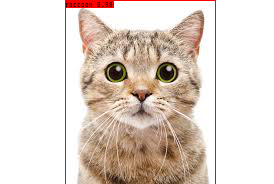

(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (76, 10) (267, 174)
0.10689900000033958


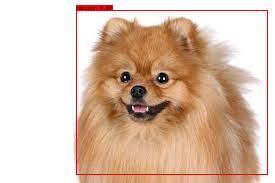

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (15, 39) (174, 171)
0.10048569999980828


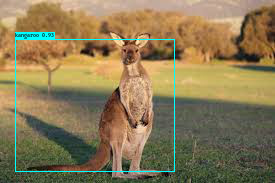

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (62, 2) (254, 154)
0.10157149999940884


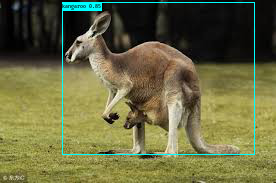

(416, 416, 3)
Found 4 boxes for img
kangaroo 0.77 (32, 62) (132, 160)
kangaroo 0.93 (183, 4) (298, 168)
kangaroo 0.93 (105, 17) (185, 156)
kangaroo 0.94 (0, 37) (72, 158)
0.10652769999978773


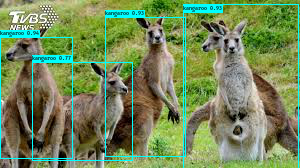

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.65 (131, 2) (226, 183)
kangaroo 0.93 (36, 10) (147, 180)
0.10264869999991788


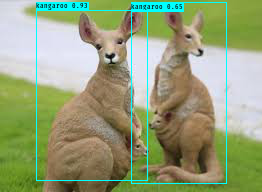

(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (34, 4) (238, 176)
0.10002050000002782


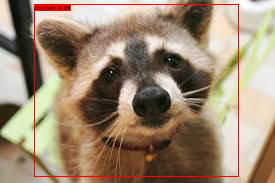

(416, 416, 3)
Found 2 boxes for img
raccoon 0.72 (100, 35) (221, 215)
raccoon 0.96 (0, 21) (124, 211)
0.10192089999964082


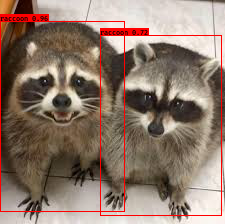

(416, 416, 3)
Found 2 boxes for img
raccoon 0.76 (0, 0) (120, 181)
raccoon 0.79 (108, 19) (253, 154)
0.10004099999969185


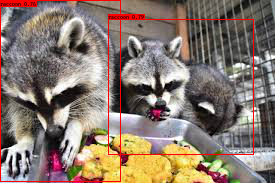

(416, 416, 3)
Found 2 boxes for img
raccoon 0.62 (8, 10) (182, 209)
raccoon 0.77 (96, 16) (225, 200)
0.10080639999978303


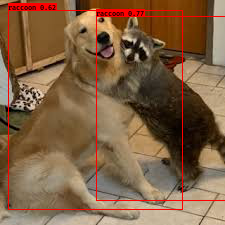

In [19]:
for file in os.listdir('../test_img/'):
    img = Image.open(os.path.join('../test_img/', file))
    r_img = yolo_model.detect_image(img)
    display.display(r_img)

In [20]:
print(log_dir)

logs/1582984894/


In [21]:
import matplotlib.pyplot as plt

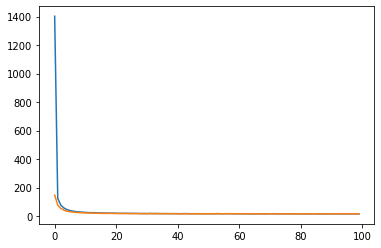

In [22]:
plt.plot(history.epoch, history.history['loss'], history.epoch, history.history['val_loss'])